In [ ]:
!pip install scipy==1.6.3
!pip install scikit_optimize==0.8.1
!pip install scikit_learn==0.24.2
! git clone https://github.com/zykhoo/SeparableNNs.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.4 MB 32.8 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 1.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 1.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires sciki

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

experiment,sys,dim = "NN","TodaLatticePatient2",6
f1 = lambda x: np.asarray([x[3], x[4], x[5]])
f2 = lambda x: np.asarray([-np.exp(x[0]-x[1])+np.exp(x[2]-x[0]),
                           -np.exp(x[1]-x[2])+np.exp(x[0]-x[1]),
                           -np.exp(x[2]-x[0])+np.exp(x[1]-x[2]),])
H = lambda x: 0.5*(x[3]**2+x[4]**2+x[5]**2)+np.exp(x[0]-x[1])+np.exp(x[1]-x[2])+np.exp(x[2]-x[0])-3

spacedim = [(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5)] # by using this spacedim, x<1 therefore x**2<1. the hamiltonian will usually be negative.
h= 0.01
x0, H0 = 0.,0.
initialcon = [64, 128, 256, 512, 1024, 2048] #, 4096, 8192
LR=0.01

"""# Test dataset creation"""

from SeparableNNs import groundtruth_2dim
from tqdm import tqdm
import time 

# xxshort,yyshort = np.linspace(spacedim[0][0], spacedim[0][1], 20), np.linspace(spacedim[1][0], spacedim[1][1], 20)
# xshort,yshort = np.meshgrid(xxshort,yyshort)

# H_true = H(np.c_[np.ravel(xshort),np.ravel(yshort)].transpose())
# sample_points = np.expand_dims(np.c_[np.ravel(xshort),np.ravel(yshort)],2)

# def get_H_grad(model, z,device):
#     inputs=torch.unsqueeze(Variable(torch.tensor([z[0][0],z[1][0]]), requires_grad = True),0).to(device)
#     out=model(inputs.float())
#     dH=torch.autograd.grad(out, inputs, grad_outputs=out.data.new(out.shape).fill_(1),create_graph=True, allow_unused=True)[0].detach().cpu().numpy()
#     return out.detach().cpu().numpy(), dH[0][1],-dH[0][0] # negative dH/dq is dp/dt

In [ ]:
# NN takes in p, q, dq, dp, and learns the Hamiltonian. The derivative of the Hamiltonian is used for integration

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn.utils.prune as prune
import numpy as np
import os
import time
from tqdm import tqdm
import math

# define model
def softplus(x):
    return torch.log(torch.exp(x)+1)

from sklearn.model_selection import train_test_split


# class sepNet(nn.Module):

#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(sepNet , self).__init__()
#         self.mask1 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(input_size/2))),torch.zeros((1,int(input_size/2)))),1),0).repeat(int(hidden_size1),1),
#             torch.squeeze(torch.cat((torch.zeros((1,int(input_size/2))),torch.ones((1,int(input_size/2)))),1),0).repeat(int(hidden_size1),1)),0)
#         self.mask2 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(hidden_size1))),torch.zeros((1,int(hidden_size1)))),1),0).repeat(int(hidden_size2),1),
#                     torch.squeeze(torch.cat((torch.zeros((1,int(hidden_size1))),torch.ones((1,int(hidden_size1)))),1),0).repeat(int(hidden_size2),1)),0)
#         self.mask3 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(hidden_size2))),torch.zeros((1,int(hidden_size2)))),1),0).repeat(int(output_size),1),
#                     torch.squeeze(torch.cat((torch.zeros((1,int(hidden_size2))),torch.ones((1,int(hidden_size2)))),1),0).repeat(int(output_size),1)),0)
#         self.hidden_layer_1 = nn.Linear( input_size, hidden_size1*2, bias=True)
#         with torch.no_grad():
#             self.hidden_layer_1.weight.mul_(self.mask1)
#         self.hidden_layer_2 = nn.Linear( hidden_size1*2, hidden_size2*2, bias=True)
#         with torch.no_grad():
#             self.hidden_layer_2.weight.mul_(self.mask2)
#         self.output_layer = nn.Linear( hidden_size2*2, output_size*2 , bias=True)
#         with torch.no_grad():
#             self.output_layer.weight.mul_(self.mask3)
#         prune.custom_from_mask(self.hidden_layer_1, name='weight', mask=self.mask1)
#         prune.custom_from_mask(self.hidden_layer_2, name='weight', mask=self.mask2)
#         prune.custom_from_mask(self.output_layer, name='weight', mask=self.mask3)
        
#     def forward(self, x):
#         x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
#         x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
#         x = self.output_layer(x)
#         x = torch.sum(x)
#         return x


# PINN
class Net(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(Net , self).__init__()
        self.hidden_layer_1 = nn.Linear( input_size, hidden_size, bias=True)
        self.hidden_layer_2 = nn.Linear( hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear( hidden_size, output_size , bias=True)
        
    def forward(self, x):
        x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
        x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
        x = self.output_layer(x)

        return x

class SumNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(SumNet , self).__init__()
        self.hidden_layer_1 = nn.Linear( input_size, hidden_size, bias=True)
        self.hidden_layer_2 = nn.Linear( hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear( hidden_size, 2 , bias=True)
        
    def forward(self, x):
        x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
        x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
        x = self.output_layer(x)
        x = torch.sum(x)

        return x

# calculate loss
def lossfuc(model,mat,x,y,device,x0,H0,dim,c1=1,c2=1,c3=1,c4=1,verbose=False):
    dim = int(wholemat.shape[1]/2)
    f3=(model(torch.tensor([[x0]*dim]).to(device))-torch.tensor([[H0]]).to(device))**2
    dH=torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1),create_graph=True, allow_unused=True)[0]
    dHdq=dH[:,:int(dim/2)]
    dHdp=dH[:,int(dim/2):]
    qprime=(mat[:,dim:int(3*dim/2)])
    pprime=(mat[:,int(3*dim/2):])
    assert dHdq.shape[1] == int(dim/2)
    assert dHdp.shape[1] == int(dim/2)
    assert qprime.shape[1] == int(dim/2)
    assert pprime.shape[1] == int(dim/2)
    f1=torch.mean((dHdp-qprime)**2,dim=0)
    # print(dHdq, pprime)
    f2=torch.mean((dHdq+pprime)**2,dim=0)
    f4=torch.mean((dHdq*qprime+dHdp*pprime)**2,dim=0)
    loss=torch.mean(c1*f1+c2*f2+c3*f3+c4*f4)
    if loss > 1000: print("errors:", f1, f2, f3, f4)
    meanf1,meanf2,meanf3,meanf4=torch.mean(c1*f1),torch.mean(c2*f2),torch.mean(c3*f3),torch.mean(c4*f4)
    if verbose:
      print(x)
      print(meanf1,meanf2,meanf3,meanf4)
      print(loss,meanf1,meanf2,meanf3,meanf4)
    return loss,meanf1,meanf2,meanf3,meanf4


def data_preprocessing(start_train, final_train,device):       
    # wholemat=[]
    # for i in range(len(start_train[0,:])):
    #     wholemat.append(np.vstack((
    #         np.hstack((start_train[:,i], (final_train[:,i]-start_train[:,i])/h)),
    #         np.hstack((final_train[:,i], (final_train[:,i]-start_train[:,i])/h)))))
    wholemat = np.hstack((start_train.transpose(), final_train.transpose()))

    wholemat =torch.tensor(wholemat)
    wholemat=wholemat.to(device)

    wholemat,evalmat=train_test_split(wholemat, train_size=0.8, random_state=1)

    return wholemat,evalmat

## train

# evaluate loss of dataset 
def get_loss(model,device,initial_conditions,bs,x0,H0,dim,wholemat,evalmat,c1,c2,c3,c4,trainset=False,verbose=False):
    # this function is used to calculate average loss of a whole dataset
    # rootpath: path of set to be calculated loss
    # model: model
    # trainset: is training set or not


    if trainset:
        mat=wholemat
    else:
        mat=evalmat
    avg_loss=0
    avg_f1=0
    avg_f2=0
    avg_f3=0
    avg_f4=0
    for count in range(0,len(mat),bs):
      curmat=mat[count:count+bs]
      x=Variable((curmat[:,:dim]).float(),requires_grad=True)
      y=model(x)
      x=x.to(device)
      loss,f1,f2,f3,f4=lossfuc(model,curmat,x,y,device,x0,H0,dim,c1,c2,c3,c4)
      avg_loss+=loss.detach().cpu().item()
      avg_f1+=f1.detach().cpu().item()
      avg_f2+=f2.detach().cpu().item()
      avg_f3+=f3.detach().cpu().item()
      avg_f4+=f4.detach().cpu().item()
    num_batches=len(mat)//bs
    avg_loss/=num_batches
    avg_f1/=num_batches
    avg_f2/=num_batches
    avg_f3/=num_batches
    avg_f4/=num_batches
    if verbose:
        print(' loss=',avg_loss,' f1=',avg_f1,' f2=',avg_f2,' f3=',avg_f3,' f4=',avg_f4)
    return avg_loss


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            上次验证集损失值改善后等待几个epoch
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            如果是True，为每个验证集损失值改善打印一条信息
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            监测数量的最小变化，以符合改进的要求
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if abs(self.counter-self.patience)<5:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''
        Saves model when validation loss decrease.
        验证损失减少时保存模型。
        '''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), 'checkpoint.pt')     # 这里会存储迄今最优模型的参数
        torch.save(model, 'checkpoint.pt')                 # 这里会存储迄今最优的模型
        self.val_loss_min = val_loss

def train(net,bs,num_epoch,initial_conditions,device,wholemat,evalmat,x0,H0,dim,LR,patience,c1,c2,c3,c4):
    # function of training process
    # net: the model
    # bs: batch size 
    # num_epoch: max of epoch to run
    # initial_conditions: number of trajectory in train set
    # patience: EarlyStopping parameter
    # c1~c4: hyperparameter for loss function


    avg_lossli,avg_f1li,avg_f2li,avg_f3li,avg_f4li=[],[],[],[],[]
    avg_vallosses=[]
    
    start = time.time()
    lr = LR # initial learning rate
    net=net.to(device)

    early_stopping = EarlyStopping(patience=patience, verbose=False,delta=0.00001) # delta
    optimizer=torch.optim.Adam(net.parameters() , lr=lr )
    for epoch in range(num_epoch):

        running_loss=0

        running_f1=0
        running_f2=0
        running_f3=0
        running_f4=0
        num_batches=0
        
        # train
        shuffled_indices=torch.randperm(len(wholemat))
        net.train()
        for count in range(0,len(wholemat),bs):
            optimizer.zero_grad()

            indices=shuffled_indices[count:count+bs]
            mat=wholemat[indices]

            x=Variable(torch.tensor(mat[:,:dim]).float(),requires_grad=True)
            y=net(x)

            loss,f1,f2,f3,f4=lossfuc(net,mat,x,y,device,x0,H0,dim,c1,c2,c3,c4)  
            loss.backward()
            torch.nn.utils.clip_grad_norm(net.parameters(), 1)

            optimizer.step()

            # compute some stats
            running_loss += loss.detach().item()
            running_f1 += f1.detach().item()
            running_f2 += f2.detach().item()
            running_f3 += f3.detach().item()
            running_f4 += f4.detach().item()

            num_batches+=1
            torch.cuda.empty_cache()



        avg_loss = running_loss/num_batches
        avg_f1 = running_f1/num_batches
        avg_f2 = running_f2/num_batches
        avg_f3 = running_f3/num_batches
        avg_f4 = running_f4/num_batches
        elapsed_time = time.time() - start
        
        avg_lossli.append(avg_loss)
        avg_f1li.append(avg_f1)
        avg_f2li.append(avg_f2)
        avg_f3li.append(avg_f3)
        avg_f4li.append(avg_f4)
        
        
        # evaluate
        net.eval()
        avg_val_loss=get_loss(net,device,len(evalmat),bs,x0,H0,dim,wholemat,evalmat,c1,c2,c3,c4)
        avg_vallosses.append(avg_val_loss)
        
        if epoch % 100 == 0 : 
            print(' ')
            print('epoch=',epoch, ' time=', elapsed_time,
                  ' loss=', avg_loss ,' val_loss=',avg_val_loss,' f1=', avg_f1 ,' f2=', avg_f2 ,
                  ' f3=', avg_f3 ,' f4=', avg_f4 , 'num_batches=', num_batches, 'percent lr=', optimizer.param_groups[0]["lr"] )
        
        
        
        early_stopping(avg_val_loss,net)
        if early_stopping.early_stop:
            print('Early Stopping')
            break
            
    net=torch.load('checkpoint.pt')
    return net,epoch,avg_vallosses,avg_lossli,avg_f1li,avg_f2li,avg_f3li,avg_f4li

class splitBalancedLinear(nn.Module):

    def __init__(self, input_size, output_size):
        # output_size is the size of one of the two parallel networks
        super(splitBalancedLinear , self).__init__()
        self.input_size, self.output_size = input_size, output_size
        weights = torch.Tensor(2,self.input_size,self.output_size)
        self.weights = nn.Parameter(weights)
        bias = torch.Tensor(2,1,self.output_size)
        self.bias = nn.Parameter(bias)

        # initialise weights and bias
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) 
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init
        
    def forward(self, x):
        # print(self.weights, self.bias)
        # print("mul", torch.einsum('ijk,ikl->ijl', x, self.weights))
        # print("add", torch.add(torch.einsum('ijk,ikl->ijl', x, self.weights), self.bias))
        return torch.add(torch.einsum('ijk,ikl->ijl', x, self.weights), self.bias)
        # return F.linear(x, self.weights, self.bias)

class sepNet(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(sepNet , self).__init__()
        self.hidden_layer_1 = splitBalancedLinear(input_size, hidden_size1)
        self.hidden_layer_2 = splitBalancedLinear(hidden_size1, hidden_size2)
        self.output_layer = splitBalancedLinear(hidden_size2, output_size)
        
    def forward(self, x):
        # print("input", x.shape)
        # print(x)
        x = torch.stack((x[:,:int(x.shape[-1]/2)],x[:,int(x.shape[-1]/2):]))
        # print(x)
        # print("initial", x.shape)
        x = softplus(self.hidden_layer_1(x)) 
        # print(x)
        # print("hl1", x.shape)
        x = softplus(self.hidden_layer_2(x)) 
        # print(x)
        # print("hl2", x.shape)
        x = self.output_layer(x)
        # print(x)
        # print("output", x.shape)
        x = torch.sum(x)
        return x

In [ ]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib import cm
from SeparableNNs.models import PINN
import torch
from SeparableNNs import metrics

for i in [17,18,19]:
  seed = i
  np.random.seed(seed=seed)
  for ini in initialcon: 

    start, final = groundtruth_2dim.CreateTrainingDataTrajStormer(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

    delta = (final-start)/h

    # delta2 = delta.copy()
    # delta2[0,:] = f1(start)
    # delta2[1,:] = f2(start)
    # dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
    # dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
    # data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

    """# sepNN"""

    

    if torch.cuda.is_available():
      device=torch.device('cuda')
    else:
      device=torch.device('cpu')
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

    import torch.optim as optim
    import time 


    sepnet = sepNet(3,22,22,1) #sepnet = sepNet(3,22,22,1)
    starttime = time.time() 
    print("training sepNet")

    results = train(sepnet,bs=min(int(len(wholemat)/5), 128),num_epoch=10000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=2500,c1=1,c2=1,c3=1,c4=1)
    # results = PINN.train(sepnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    sepnet, epochs = results[0], results[1]
    septraintime = time.time()-starttime
    torch.save(sepnet.state_dict(), '/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini))

    # H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    # for i in tqdm(range(len(sample_points))):
    #   out = get_H_grad(sepnet, sample_points[i], device)
    #   H_pred[i] = out[0]
    #   dq_pred[i] = out[1]
    #   dp_pred[i] = out[2]
    # print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    # file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a') 
    # file_object.write('sepNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
    #       %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
    #       np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
    #       np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    # file_object.close()
    
    # H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

    # plt.figure(figsize = (10,10))
    # plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    # plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    # plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sepNN"))

    net = Net(6,31,1)
    starttime = time.time() 
    print("training PINN Net")
    
    results = train(net,bs=min(int(len(wholemat)/5), 128),num_epoch=10000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=2500,c1=1,c2=1,c3=1,c4=1)
    net, epochs = results[0], results[1]
    PINNtraintime = time.time()-starttime
    torch.save(net.state_dict(), '/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini))

    # H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    # for i in tqdm(range(len(sample_points))):
    #   out = get_H_grad(net, sample_points[i], device)
    #   H_pred[i] = out[0]
    #   dq_pred[i] = out[1]
    #   dp_pred[i] = out[2]
    # print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    # file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a')
    # file_object.write('PINN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
    #       %(ini, seed, dq_MSE, dp_MSE, data_MSE, PINNtraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
    #       np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
    #       np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    # file_object.close()
    
    # H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)
    
    # plt.figure(figsize = (10,10))
    # plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    # plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    # plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "PINN"))

    # print(septraintime, PINNtraintime)

training sepNet
 
epoch= 0  time= 0.09438347816467285  loss= 1.1458559617700586  val_loss= 1.0134704782286816  f1= 0.07958626145171943  f2= 0.6625422705836956  f3= 0.40365204370270175  f4= 7.538603194194305e-05 num_batches= 6 percent lr= 0.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:258: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:263: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Streaming output truncated to the last 5000 lines.
epoch= 2600  time= 65.61757278442383  loss= 0.00017985901305332566  val_loss= 0.00020268933641758203  f1= 5.924204120165245e-05  f2= 6.526741261143277e-05  f3= 8.839543227168178e-06  f4= 4.6510016013072264e-05 num_batches= 6 percent lr= 0.01
 
epoch= 2700  time= 68.06817054748535  loss= 0.0001504372982815526  val_loss= 0.00017207405270560093  f1= 4.2792456403721985e-05  f2= 5.5994466284428244e-05  f3= 1.0285942655248922e-05  f4= 4.136443293815348e-05 num_batches= 6 percent lr= 0.01
 
epoch= 2800  time= 70.59030199050903  loss= 0.0022650168303458107  val_loss= 0.003249241226795584  f1= 0.00020098785212744103  f2= 0.0017384350315669944  f3= 0.0001038470711307582  f4= 0.0002217468755206164 num_batches= 6 percent lr= 0.01
 
epoch= 2900  time= 73.27271270751953  loss= 0.0001372388896727395  val_loss= 0.00019583264605551573  f1= 4.512347409871458e-05  f2= 5.3467828977771724e-05  f3= 2.399591470710523e-07  f4= 3.840762744918215e-05 num_batche

In [ ]:
n_sample = 20
dim = 6

z = torch.tensor(np.array(np.meshgrid(np.linspace(spacedim[0][0], spacedim[0][1], n_sample),np.linspace(spacedim[1][0], spacedim[1][1],n_sample),
                                      np.linspace(spacedim[2][0], spacedim[2][1],n_sample),np.linspace(spacedim[3][0], spacedim[3][1],n_sample),
                                      np.linspace(spacedim[4][0], spacedim[4][1],n_sample),np.linspace(spacedim[5][0], spacedim[5][1],n_sample),
                                      ))).reshape(6, n_sample**dim).transpose(1,0)
for i in tqdm(range(dim**2)):
  np.savetxt('test%s.txt' %(i), z[n_sample**4*i:n_sample**4*(i+1), :])

100%|██████████| 36/36 [00:46<00:00,  1.30s/it]


In [ ]:
from tqdm import tqdm

n_sample = 20 # 6

sepnet_total, net_total = [],[]
for seed in tqdm(range(20)):
  for ini in initialcon:
    net = Net(6,31,1)
    net.load_state_dict(torch.load('/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini)))

    sepnet = sepNet(3,22,22,1) #PINN.sepNet(2,11,11,1)
    sepnet.load_state_dict(torch.load('/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini)))

    def get_grad(model, z,device):
      inputs=Variable(z.clone().detach()).requires_grad_(True).to(device)
      out=model(inputs.float())
      dH=torch.autograd.grad(out, inputs, grad_outputs=out.data.new(out.shape).fill_(1),create_graph=True)[0]
      return np.asarray([dH.detach().cpu().numpy()[:,3], dH.detach().cpu().numpy()[:,4], dH.detach().cpu().numpy()[:,5],
                         -dH.detach().cpu().numpy()[:,0], -dH.detach().cpu().numpy()[:,1], -dH.detach().cpu().numpy()[:,2], ]) # negative dH/dq is dp/dt
      # return np.asarray([dH.detach().to(device).numpy()[:,3], dH.detach().to(device).numpy()[:,4], dH.detach().to(device).numpy()[:,5],
      #               -dH.detach().to(device).numpy()[:,0], -dH.detach().to(device).numpy()[:,1], -dH.detach().to(device).numpy()[:,2], ]) # negative dH/dq is dp/dt

    
    f1 = lambda x: np.stack([x[:,3], x[:,4], x[:,5]])
    f2 = lambda x: np.stack([-np.exp(x[:,0]-x[:,1])+np.exp(x[:,2]-x[:,0]),
                              -np.exp(x[:,1]-x[:,2])+np.exp(x[:,0]-x[:,1]),
                              -np.exp(x[:,2]-x[:,0])+np.exp(x[:,1]-x[:,2]),])



    fvec = lambda z: np.concatenate([f1(z), f2(z)])
    error = lambda x,y: np.sum(np.sqrt(np.sum((x-y)**2,0))/np.sqrt(np.sum(x**2,0))) # where x is the true vector and y is the approximated vector

    

    sepnet_error, net_error = 0, 0
    for i in range(dim**2):
      inpz = torch.tensor(np.loadtxt('test%s.txt' %(i)))
      sepnet_error += error(fvec(inpz), get_grad(sepnet, inpz, 'cpu'))
      net_error += error(fvec(inpz), get_grad(net, inpz, 'cpu'))
    sepnet_total.append(sepnet_error)
    net_total.append(net_error)
    print(ini, net_error, sepnet_error)

  0%|          | 0/20 [00:00<?, ?it/s]

64 110732.59608824868 132521.3941246751
128 87596.9599491072 56171.78548218555
256 60956.967101608614 40441.535692907775
512 44899.1225054379 36292.11785323397
1024 37829.201889261996 20216.55465455176


  5%|▌         | 1/20 [08:00<2:32:10, 480.55s/it]

2048 33636.18251887308 20486.88120416685
64 210634.97440338216 62213.44449666965
128 81765.13351684411 93309.46166739534
256 59320.59992796067 71322.51028198075
512 53452.77531100058 42633.174510049794
1024 38551.4951603593 35252.2035794909


 10%|█         | 2/20 [15:58<2:23:38, 478.81s/it]

2048 38838.76052674931 29027.12829766424
64 129991.6874224033 73427.96404412531
128 93047.96399467997 48601.03138890481
256 73720.83495723605 36885.63098518623
512 47444.64044071185 31908.088496787168
1024 34184.28153363605 17771.21118423455


 15%|█▌        | 3/20 [23:50<2:14:49, 475.86s/it]

2048 33314.56389772105 22021.307644700446
64 141399.22788272047 131759.5061064728
128 87184.33778450116 38909.01260747464
256 69216.922065935 37639.47688342976
512 53783.7746576101 34622.25948158185
1024 33195.36588091139 22710.166429808312


 20%|██        | 4/20 [31:44<2:06:40, 475.03s/it]

2048 33608.12051050877 16361.565710831614
64 144637.4906892436 87261.42375878968
128 72943.27452404605 60080.18779070865
256 56640.409341687504 57567.9332550336
512 48044.7337102661 28523.00273262589
1024 41037.50414708987 25193.378706137686


 25%|██▌       | 5/20 [39:52<1:59:58, 479.91s/it]

2048 36208.87245903011 25053.5237849265
64 105380.05416934422 67993.59172363272
128 82955.53422574548 54063.94885877167
256 52888.053557480336 39845.13375627392
512 49455.30579468481 31471.093600536988
1024 39874.93589923258 25817.98225180421


 30%|███       | 6/20 [48:02<1:52:46, 483.32s/it]

2048 32472.681993597722 19671.395686799722
64 145796.87969179184 62819.58495256345
128 66154.41217170573 52354.32896729949
256 70184.58511132842 43372.8091750271
512 56490.282145249344 37844.32990430036
1024 42899.12421596381 19656.21577898098


 35%|███▌      | 7/20 [56:08<1:44:53, 484.08s/it]

2048 37621.08245400782 20187.06757884237
64 109200.34229627937 83016.88445296905
128 69257.26175611984 43977.81839326481
256 59850.385105495996 43623.429119108696
512 41562.49655554933 34711.04249357402
1024 36432.64238948263 28060.34529048826


 40%|████      | 8/20 [1:04:13<1:36:54, 484.51s/it]

2048 33272.61362425548 29921.806710554152
64 165872.44971802447 89075.59030879133
128 96584.69137898234 43761.35393959854
256 62828.52716812224 37196.69629199382
512 52110.9233765643 23396.288664489726
1024 41412.00489954408 33717.65301263065


 45%|████▌     | 9/20 [1:12:18<1:28:48, 484.42s/it]

2048 39417.28842968313 30143.104423171215
64 136670.79301928327 78099.54209936259
128 135703.76068760912 45722.584267670776
256 61280.12519901512 34668.13735664524
512 46437.29046014902 35682.79533083139
1024 32726.93788763692 24839.720897152303


 50%|█████     | 10/20 [1:20:22<1:20:42, 484.29s/it]

2048 35808.11762823999 20803.550958857733
64 141328.47333205194 67850.64199132787
128 93652.80117838686 50622.96627488935
256 71268.33304581998 42423.87442375359
512 42869.30887138916 36551.4281284112
1024 35362.49675468529 24217.473528703416


 55%|█████▌    | 11/20 [1:28:26<1:12:38, 484.30s/it]

2048 30459.222986023815 26873.8999171449
64 176026.34184117 82210.57762801791
128 67300.72134352571 45894.92391870333
256 64581.69360380389 39587.98607234366
512 40892.784500567344 44602.09954886566
1024 38965.52236532703 30069.110263836592


 60%|██████    | 12/20 [1:36:32<1:04:39, 485.00s/it]

2048 32442.40208573677 25823.094367230286
64 175832.54307396183 82074.51232603543
128 86077.91315865776 45913.252782303454
256 53920.52367527993 37354.634096336726
512 44949.94095491373 30146.776753957274
1024 39740.95921472156 23955.258264352164


 65%|██████▌   | 13/20 [1:44:37<56:33, 484.84s/it]  

2048 30139.421124093984 25962.545268892063
64 110181.41421271492 89625.43947260194
128 91746.3911731445 55998.90556575758
256 64666.25287884491 34054.249513629875
512 51920.98111730435 25016.579001451195
1024 38255.383739539386 26371.507061020482


 70%|███████   | 14/20 [1:52:42<48:29, 485.00s/it]

2048 32145.867914019873 20514.94117418312
64 128116.9385958862 66384.1192170716
128 83466.42890331945 47312.94669444542
256 71252.97458052452 50642.94998591853
512 59838.090110190606 31122.470447551284
1024 42418.91688232778 23959.92883789317


 75%|███████▌  | 15/20 [2:00:47<40:23, 484.78s/it]

2048 34012.504313472185 27507.6577540221
64 182602.7022887448 187545.72823554464
128 142846.66772910656 54583.28401827799
256 61318.350913123904 45111.34249031647
512 57446.029569509075 41678.07828457342
1024 45110.82768561432 27728.22339909469


 80%|████████  | 16/20 [2:08:54<32:21, 485.46s/it]

2048 30221.880078081984 23581.23358946674
64 152322.31207484772 100439.6661095603
128 105089.94715120562 68077.79123733572
256 72594.5109203279 35860.7415331477
512 53149.23834760864 25672.055906101265
1024 35804.4909528805 22047.714936098364


 85%|████████▌ | 17/20 [2:16:57<24:14, 484.81s/it]

2048 29531.709219536388 25561.392455896963
64 128829.24329422822 77625.55898569153
128 84789.54417784249 42719.75351071697
256 54447.122218299555 38349.5398998725
512 46734.41998846119 23935.907865403475
1024 38550.266583389115 19888.966457717266


 90%|█████████ | 18/20 [2:24:58<16:07, 483.70s/it]

2048 40294.9633249646 16852.39829664532
64 103863.00423395856 71697.28398904359
128 81339.56229128227 50179.029215620154
256 56106.837545813374 38730.70604069834
512 41644.29736693481 34193.00322838326
1024 35205.86061882293 27506.103277164777


 95%|█████████▌| 19/20 [2:33:02<08:03, 483.73s/it]

2048 39331.33779603623 21491.13783247039
64 150989.881617574 86392.8204922918
128 84475.9643543242 47650.34055679713
256 65750.17022300974 32206.188331424346
512 45446.786794510685 37374.53383046021
1024 43088.14852807767 26879.33230050623


100%|██████████| 20/20 [2:41:12<00:00, 483.64s/it]

2048 33863.8661621785 25291.78811722433


In [ ]:
sepnet_total, net_total = [np.mean(sepnet_total[i::len(initialcon)]) for i in range(len(initialcon))], [np.mean(net_total[i::len(initialcon)]) for i in range(len(initialcon))]

In [ ]:
sepnet_total, net_total

([89001.76372576192,
  52295.235356906065,
  41844.27525925143,
  33368.85630315846,
  25292.95250558334,
  23656.871038684552],
 [142520.46749729296,
  89698.96357250681,
  63139.70895703589,
  48928.661128930646,
  38532.31836142521,
  34332.072952340546])

In [1]:
sepnet_total = [89001.76372576192,
  52295.235356906065,
  41844.27525925143,
  33368.85630315846,
  25292.95250558334,
  23656.871038684552]
net_total = [142520.46749729296,
  89698.96357250681,
  63139.70895703589,
  48928.661128930646,
  38532.31836142521,
  34332.072952340546]

In [3]:
import matplotlib.pyplot as plt
import numpy as np

initialcon = [64,128,256,512,1024,2048]
fig, ax = plt.subplots(figsize = (10,8), dpi = 1200)
l1 = ax.scatter(initialcon, sepnet_total, label = "sepnet absolute error", s=100)
l2 = ax.scatter(initialcon, net_total, label = "net absolute error", s=100)
# ax.set_ylabel('absolute error')
ax.set_ylim(0,max(max(sepnet_total), max(net_total))*1.03)
ax2 = ax.twinx()
l3 = ax2.plot(initialcon, np.maximum(np.zeros(6), (np.array(net_total)-np.array(sepnet_total))/np.array(net_total)*100), color = "lightblue", linewidth = 5.0, alpha = 0.5, label = "percentage improvement")
# ax2.set_ylabel('percentage error reduction')
ax2.set_ylim(0,100)
plt.xscale("log")
plt.xticks([64,128,256,512,1024,2048],[64,128,256,512,1024,2048])
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes, fontsize=28)
plt.savefig("todalattice_large",bbox_inches='tight')

In [ ]:
y = (np.array(net_total)[0:6]-np.array(sepnet_total)[0:6])/np.array(net_total)[0:6]*100
print("%.3f & %.3f & %.3f & %.3f & %.3f & %.3f" %(y[0], y[1], y[2], y[3], y[4], y[5]))

37.552 & 41.699 & 33.727 & 31.801 & 34.359 & 31.094


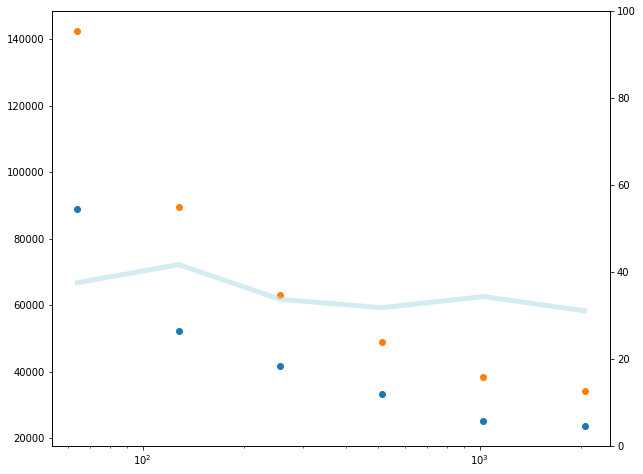

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,8))
l1 = ax.scatter(initialcon, sepnet_total, label = "sepnet absolute error")
l2 = ax.scatter(initialcon, net_total, label = "net absolute error")
# ax.set_ylabel('absolute error')
ax2 = ax.twinx()
l3 = ax2.plot(initialcon, np.maximum(np.zeros(6), (np.array(net_total)-np.array(sepnet_total))/np.array(net_total)*100), color = "lightblue", linewidth = 5.0, alpha = 0.5, label = "percentage error reduction")
# ax2.set_ylabel('percentage error reduction')
ax2.set_ylim(0,100)
plt.xscale("log")
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

In [ ]:
# import matplotlib.pyplot as plt
# from torch.autograd import Variable
# from matplotlib import cm
# from understandingPINNs.models import PINN
# import torch
# from understandingPINNs import metrics

# for i in range(20):
#   seed = i
#   np.random.seed(seed=seed)
#   for ini in initialcon: 

#     start, final = groundtruth_2dim.CreateTrainingDataTrajStormer(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

#     delta = (final-start)/0.1
#     delta2 = delta.copy()
#     delta2[0,:] = f1(start)
#     delta2[1,:] = f2(start)
#     dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
#     dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
#     data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

#     """# sumNN"""

    

#     if torch.cuda.is_available():
#       device=torch.device('cuda')
#     else:
#       device=torch.device('cpu')
#     print("device used", device)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)

#     wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

#     import torch.optim as optim
#     import time 


#     sumnet = PINN.SumNet(2,16,2)
#     starttime = time.time() 

#     results = PINN.train(sumnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
#     sumnet, epochs = results[0], results[1]
#     septraintime = time.time()-starttime
#     torch.save(sumnet.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.pt' %(sys,sys,"sumNN",seed,ini))

#     H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
#     for i in tqdm(range(len(sample_points))):
#       out = get_H_grad(sumnet, sample_points[i], device)
#       H_pred[i] = out[0]
#       dq_pred[i] = out[1]
#       dp_pred[i] = out[2]
#     print(H_pred.shape, dq_pred.shape, dp_pred.shape)
#     file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a') 
#     file_object.write('sumNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
#           %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
#           np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
#           np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
#     file_object.close()
    
#     H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

#     plt.figure(figsize = (10,10))
#     plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
#     plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
#     plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sumNN"))

In [ ]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib import cm
from understandingPINNs.models import PINN
import torch
from understandingPINNs import metrics

for i in [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]:
  seed = i
  np.random.seed(seed=seed)
  for ini in initialcon: 

    start, final = groundtruth_2dim.CreateTrainingDataTrajSympEuler(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

    delta = (final-start)/0.1
    delta2 = delta.copy()
    delta2[0,:] = f1(start)
    delta2[1,:] = f2(start)
    dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
    dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
    data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

    """# sepNN"""

    

    if torch.cuda.is_available():
      device=torch.device('cuda')
    else:
      device=torch.device('cpu')
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

    import torch.optim as optim
    import time 


    sepnet = PINN.sepNet(1,11,11,1)
    starttime = time.time() 

    results = PINN.train(sepnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    sepnet, epochs = results[0], results[1]
    septraintime = time.time()-starttime
    torch.save(sepnet.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini))

    H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    for i in tqdm(range(len(sample_points))):
      out = get_H_grad(sepnet, sample_points[i], device)
      H_pred[i] = out[0]
      dq_pred[i] = out[1]
      dp_pred[i] = out[2]
    print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_results.txt' %(sys,sys), 'a') 
    file_object.write('sepNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
          %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
          np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
          np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    file_object.close()
    
    H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

    plt.figure(figsize = (10,10))
    plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sepNN"))

    net = PINN.Net(2,16,1)
    starttime = time.time() 
    
    results = PINN.train(net,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    net, epochs = results[0], results[1]
    PINNtraintime = time.time()-starttime
    torch.save(net.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini))

    H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    for i in tqdm(range(len(sample_points))):
      out = get_H_grad(net, sample_points[i], device)
      H_pred[i] = out[0]
      dq_pred[i] = out[1]
      dp_pred[i] = out[2]
    print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_results.txt' %(sys,sys), 'a')
    file_object.write('PINN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
          %(ini, seed, dq_MSE, dp_MSE, data_MSE, PINNtraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
          np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
          np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    file_object.close()
    
    H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)
    
    plt.figure(figsize = (10,10))
    plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "PINN"))

    print(septraintime, PINNtraintime)